In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import re
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from utility import *
import lightgbm as lgbm
import warnings
warnings.filterwarnings('ignore')
from typing import List, Optional, Tuple
from sklearn.calibration import calibration_curve

In [2]:
dataset = "real777"
model_name = "LGBM"

(
    data,
    baseline_data,
    baseline_data_cont,
    follow_up_predictors_total,
    follow_up_predictors_vars_by_year,
    follow_up_predictors_cont,
) = data_extraction(dataset)

## sub group prediction performance time agnostic

In [4]:
binary_group_cols = ['sex', 'First_Tpx', 'dontype_livingVSdeath']
special_binary_group_cols = ['dontype_living_relatedVSunrelated', 'dontype_death_DBDVSDCD']
multi_class_group_cols = ['bg', 'ethnicity', 'procedure_provider']
result_df = pd.read_csv(
    f"{dataset}/results/next_year_prediction_results_{model_name}_multi_year_training_best_model.csv", index_col=0
)

baseline_result = result_df.loc[result_df['target_year'] == 1]
follow_up_result = result_df.loc[result_df['target_year'] != 1]
all_group_cols = binary_group_cols + special_binary_group_cols + multi_class_group_cols
all_group_cols = list(dict.fromkeys(all_group_cols))  # remove duplicates if needed

sns.set_style("white")
sns.set_context("talk", font_scale=1.2)

name_mapping = {
    "sex": "Sex (Female=0, Male=1)",
    "First_Tpx": "First Transplant",
    "dontype_livingVSdeath": "Living vs. Deceased Donor",
    "dontype_living_relatedVSunrelated": "Living Donor: Related vs. Unrelated",
    "dontype_death_DBDVSDCD": "Deceased Donor: DBD vs. DCD",
    "bg": "ABO Blood Group",
    "ethnicity": "Ethnicity",
    "procedure_provider": "Transplant Center"
    # etc.
}

PALETTE = sns.color_palette("Set2")

def compute_metric(y_true, y_prob, metric):
    """Returns AUROC or AUPRC for the given true labels and predicted probabilities."""
    if metric == 'AUROC':
        return roc_auc_score(y_true, y_prob)
    elif metric == 'AUPRC':
        return average_precision_score(y_true, y_prob)
    else:
        raise ValueError(f"Unknown metric: {metric}")

def make_subgroup_barplot(merged_df, group_col, outcome_type, metric, ax=None):
    """
    Compute the metric within each level of group_col and plot as a bar chart.
    """
    # Define blues-only palette
    PALETTE = sns.color_palette("Blues", n_colors=8)
    prevalence_color = '#063970'  # Deep blue for prevalence
    
    # 1) Subset to the correct outcome
    df_sub = merged_df[merged_df['outcome_type'] == outcome_type].copy()
    if df_sub.empty:
        ax.set_title(f"{name_mapping.get(group_col, group_col)}\n(No rows!)", fontsize=14)
        return
        
    # 2) Drop rows missing group_col or label/prob
    df_sub = df_sub.dropna(subset=[group_col, 'label', 'prob'])
    if df_sub.empty:
        ax.set_title(f"{name_mapping.get(group_col, group_col)}\n(No data!)", fontsize=14)
        return
        
    # 3) Compute metric and prevalence in each subgroup
    metrics_per_group = {}
    prevalence_per_group = {}
    
    for grp_val, grp_df in df_sub.groupby(group_col):
        y_true = grp_df['label']
        y_prob = grp_df['prob']
        prevalence_per_group[grp_val] = y_true.mean()
        if len(y_true.unique()) < 2:
            metrics_per_group[grp_val] = np.nan
        else:
            metrics_per_group[grp_val] = compute_metric(y_true, y_prob, metric)
            
    if not metrics_per_group:
        ax.set_title(f"{name_mapping.get(group_col, group_col)}\n(No valid subgroups!)", fontsize=14)
        return
        
    # 4) Prepare for plotting
    x_vals = list(metrics_per_group.keys())
    y_vals = list(metrics_per_group.values())
    x_vals, y_vals = zip(*sorted(zip(x_vals, y_vals), key=lambda x: x[0]))
    positions = np.arange(len(x_vals))
    
    # 5) Bar plot with blues palette
    colors = PALETTE[:len(x_vals)]
    sns.barplot(x=list(x_vals), y=list(y_vals), ax=ax, palette=colors)
    
    # Add value labels
    for i, patch in enumerate(ax.patches):
        height = patch.get_height()
        if not np.isnan(height):
            ax.text(
                patch.get_x() + patch.get_width() / 2,
                height + 0.01,
                f"{height:.3f}",
                ha="center", va="bottom", fontsize=10
            )
    
    # 6) Plot prevalence with deep blue markers
    if metric == "AUPRC":
        prevalences = [prevalence_per_group[val] for val in x_vals]
        ax.scatter(
            positions,
            prevalences,
            color=prevalence_color,
            marker="D",
            s=60,
            zorder=10,
            label="Prevalence"
        )
        ax.legend(loc="upper right", fontsize=10)
    
    # 7) Axis formatting
    ax.set_xticklabels(x_vals, rotation=45, ha='right')
    if metric == "AUROC":
        ax.set_ylim(0, 1)
    ax.set_title(name_mapping.get(group_col, group_col), fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    sns.despine(ax=ax, top=True, right=True)

def subgroup_analysis_plots(
    follow_up_result,  
    data,              
    group_cols,
    outcome_types=('death', 'graft_loss'),
    metrics=('AUROC', 'AUPRC')
):
    """
    Create 4 figures in total:
      1) Death,  AUROC
      2) Death,  AUPRC
      3) Graft,  AUROC
      4) Graft,  AUPRC
    Each figure has one subplot per group column in 'group_cols'.
    Overlaps prevalence (fraction of positives) on the AUPRC plots.
    """

    # Merge on patient ID
    merged = follow_up_result.join(data, how='left')

    # Plot for each outcome + metric
    for outcome_type in outcome_types:
        for metric in metrics:
            fig, axes = plt.subplots(
                1, len(group_cols),
                figsize=(4 * len(group_cols), 6.5),
                sharey=True
            )
            if len(group_cols) == 1:
                axes = [axes]

            fig.suptitle(f"{outcome_type.capitalize()} — {metric}", fontsize=16, y=1.02)

            for ax, gcol in zip(axes, group_cols):
                # Filter for special columns
                if gcol == 'dontype_living_relatedVSunrelated':
                    sub_merged = merged[merged['dontype_livingVSdeath'] == 1]
                    make_subgroup_barplot(sub_merged, gcol, outcome_type, metric, ax=ax)
                elif gcol == 'dontype_death_DBDVSDCD':
                    sub_merged = merged[merged['dontype_livingVSdeath'] == 0]
                    make_subgroup_barplot(sub_merged, gcol, outcome_type, metric, ax=ax)
                else:
                    make_subgroup_barplot(merged, gcol, outcome_type, metric, ax=ax)

            plt.tight_layout()
            plt.savefig(f'Manuscript Figures/subcohort analysis {outcome_type} {metric}.png',bbox_inches ='tight', dpi=300)
            plt.show()

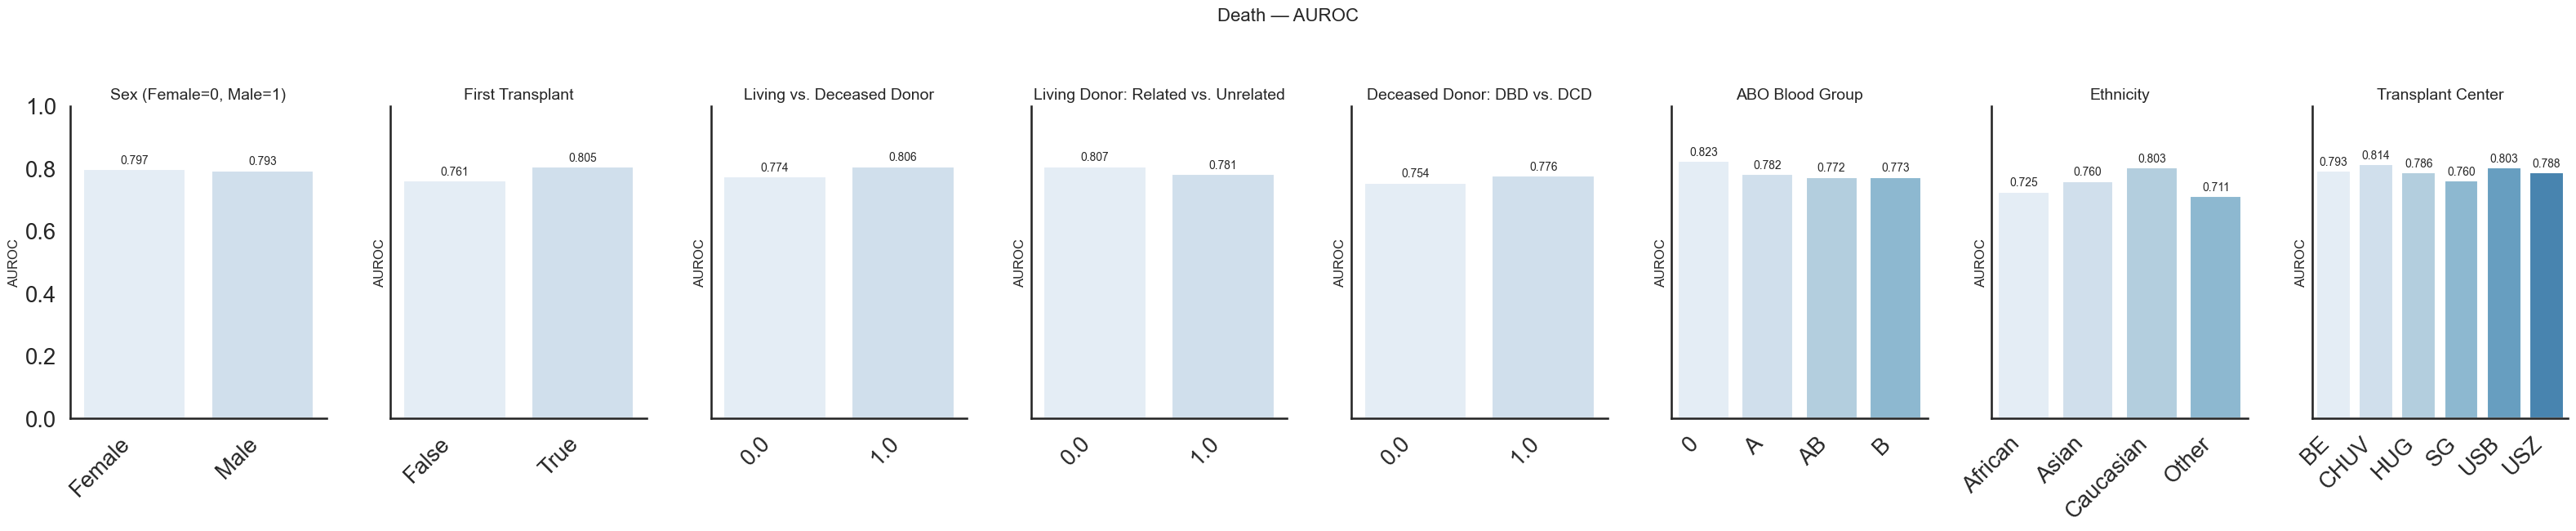

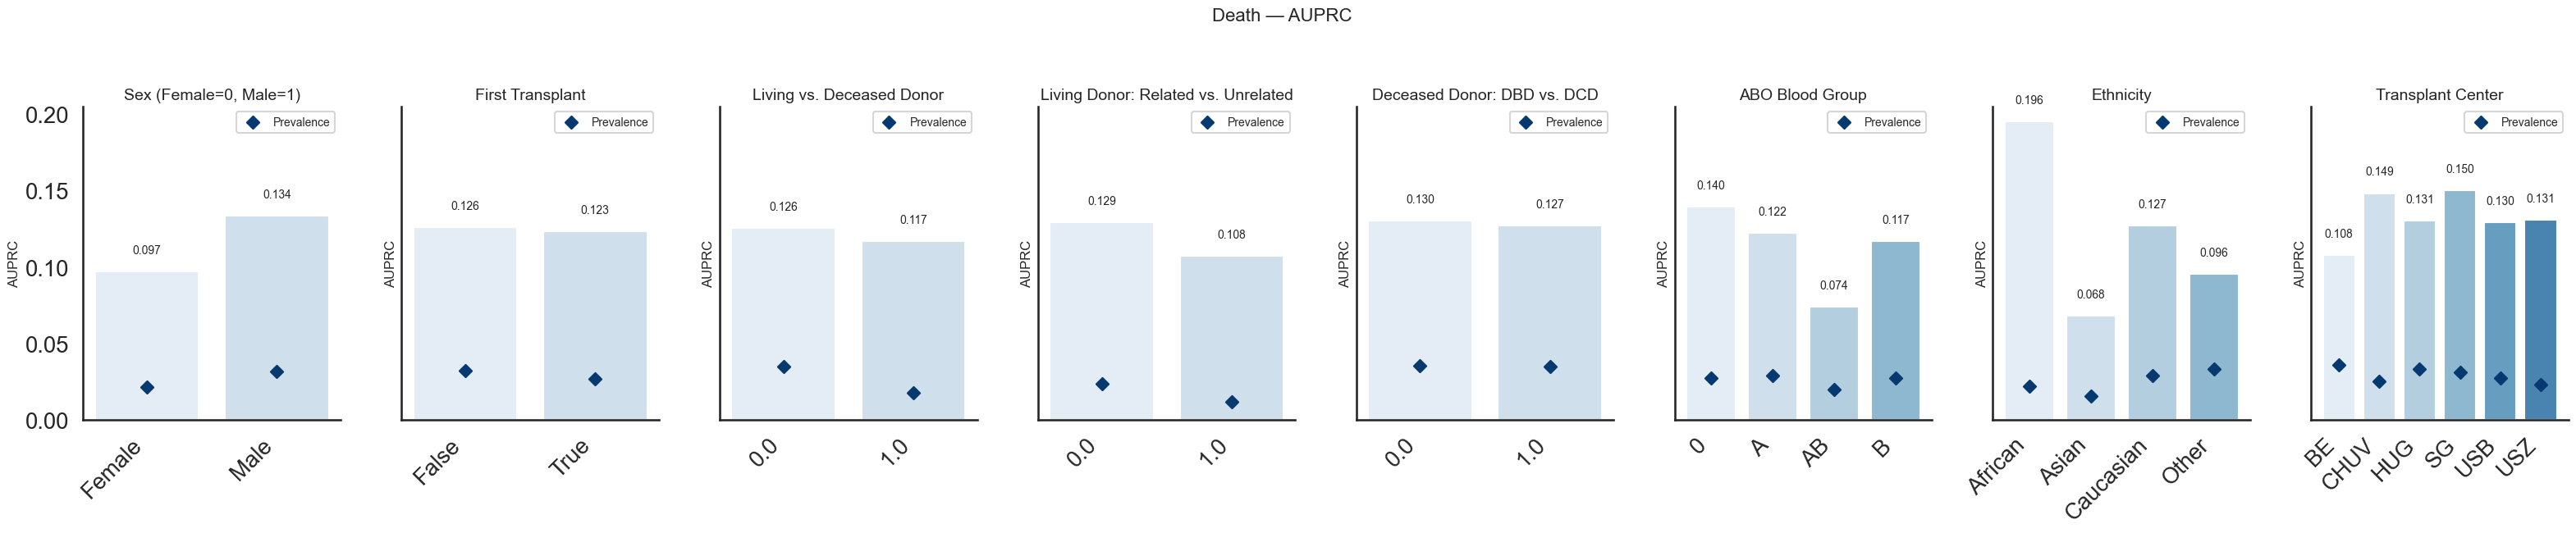

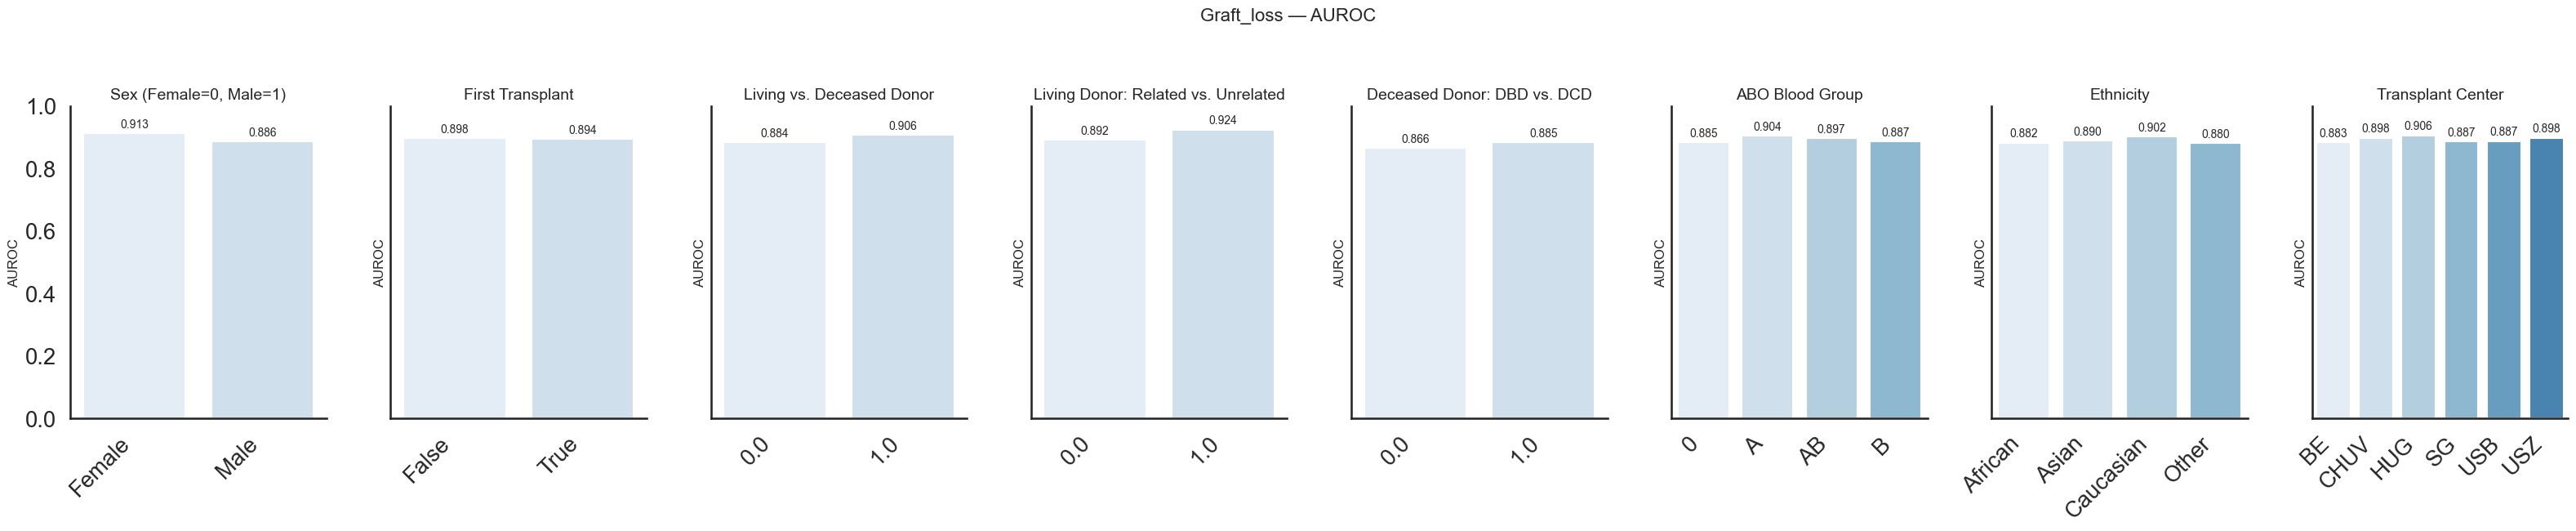

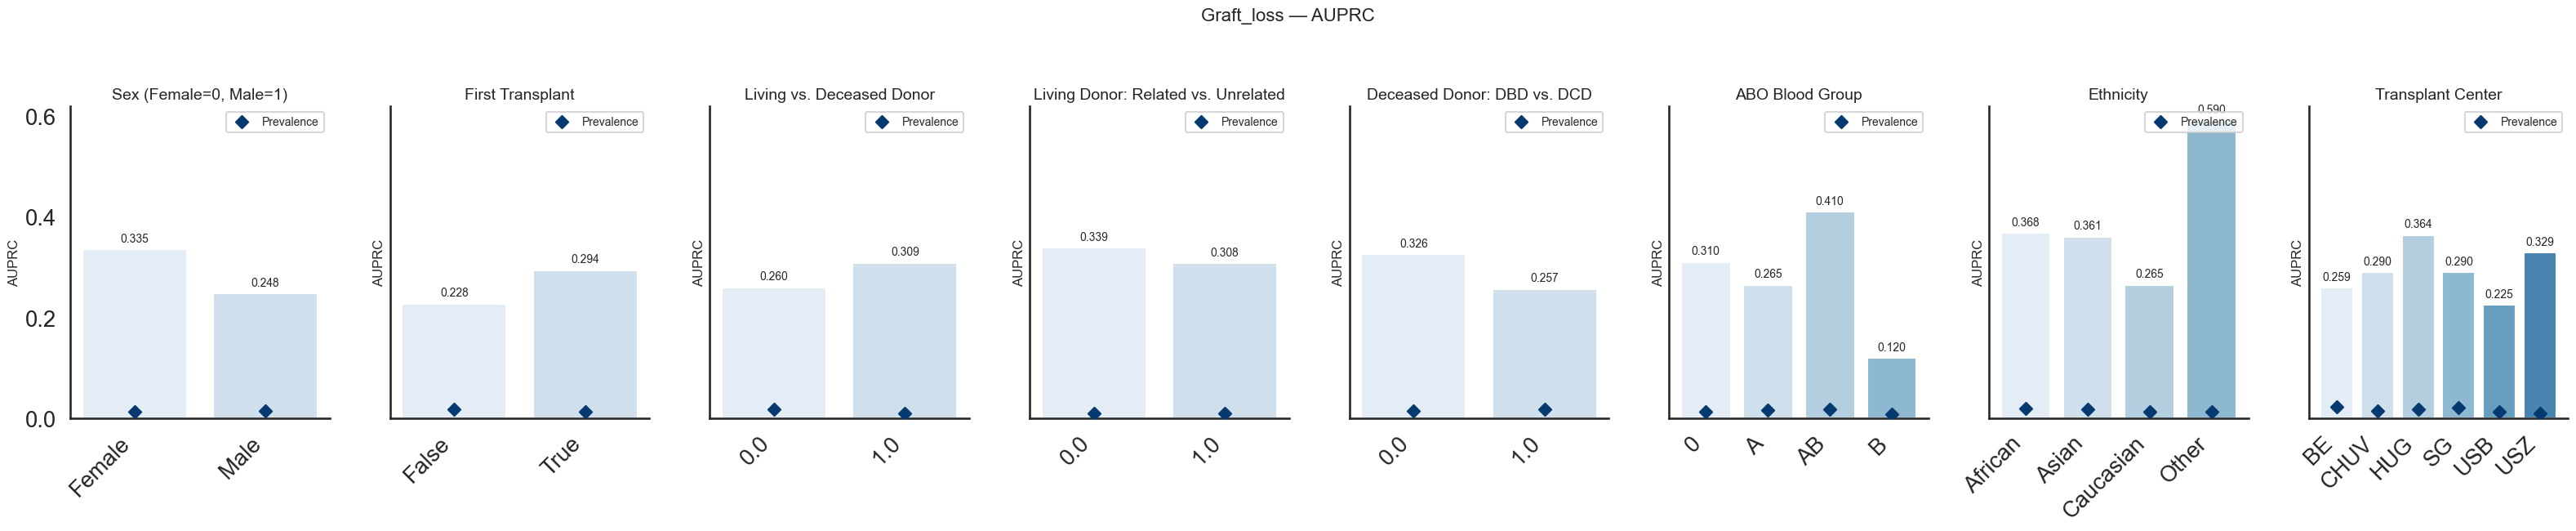

In [5]:
all_predictions = follow_up_result   # your DF with columns [label, outcome_type, prob]
subgroup_data   = data               # patient-level info with columns [sex, dontype_..., First_Tpx, ...]

subgroup_analysis_plots(
    follow_up_result=all_predictions,
    data=subgroup_data,
    group_cols=binary_group_cols + special_binary_group_cols + multi_class_group_cols
)


## cross-group training and validation

In [4]:
dataset = "real777"
(
    data,
    baseline_data,
    baseline_data_cont,
    follow_up_predictors_total,
    follow_up_predictors_vars_by_year,
    follow_up_predictors_cont,
) = data_extraction(dataset)
outcome_data = data[primary_outcomes]
outcome_data = transform_outcomes(outcome_data)

In [5]:
def get_input_data_for_outcome_multi_year(
    outcome,
    baseline_data,
    baseline_data_cont,
    follow_up_predictors_total,
    follow_up_predictors_vars_by_year,
    follow_up_predictors_cont,
):
    match = re.search(r"_y(\d+)", outcome)
    if not match:
        raise ValueError(f"Could not extract year from outcome: {outcome}")
    outcome_year = int(match.group(1))
    assert outcome_year != 1

    previous_year = outcome_year - 1
    follow_input_vars = follow_up_predictors_vars_by_year[f"y{previous_year}"]

    name_mapping = {col: clean_follow_up_names(col) for col in follow_input_vars}
    follow_up_data = follow_up_predictors_total[follow_input_vars].copy()
    follow_up_data.columns = [name_mapping[col] for col in follow_up_data.columns]
    combined_data = pd.concat([baseline_data, follow_up_data], axis=1)
    cleaned_follow_up_cont = [
        clean_follow_up_names(col) for col in follow_up_predictors_cont.columns
    ]
    cont_vars = (
        baseline_data_cont.columns.tolist()
        + follow_up_data.columns[
            follow_up_data.columns.isin(cleaned_follow_up_cont)
        ].tolist()
    )
    return combined_data, cont_vars


def preprocess_data(
    X: pd.DataFrame, cont_vars: List[str], scaler=None
) -> Tuple[pd.DataFrame, StandardScaler]:
    """Preprocess data by scaling continuous variables and handling missing values."""
    X_processed = X.copy()

    if scaler is None:
        scaler = StandardScaler()
        X_processed.loc[:, cont_vars] = scaler.fit_transform(X_processed[cont_vars])
    else:
        X_processed.loc[:, cont_vars] = scaler.transform(X_processed[cont_vars])

    # Handle missing values
    X_processed = X_processed.fillna(0)

    return X_processed, scaler


def fit_and_evaluate(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    model,
) -> Tuple[float, float, float, float]:
    """Fit model and evaluate performance on validation and test sets."""
    # For small datasets, use all CPU cores
    if hasattr(model, "n_jobs"):
        model.n_jobs = -1

    # Add early stopping for LGBM
    if isinstance(model, lgbm.LGBMClassifier):
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    else:
        model.fit(X_train, y_train)

    y_val_pred = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]

    metrics = {
        "val_auprc": average_precision_score(y_val, y_val_pred),
        "val_auroc": roc_auc_score(y_val, y_val_pred),
        "test_auprc": average_precision_score(y_test, y_test_pred),
        "test_auroc": roc_auc_score(y_test, y_test_pred),
    }

    return metrics

def return_model(model_name, best_params, outcome_key):
    if model_name == "LGBM":
        # Calculate class weights
        model = lgbm.LGBMClassifier(**best_params[outcome_key], verbosity=-1)
    elif model_name == "LR":
        model = LogisticRegression(
            **best_params[outcome_key],
            max_iter=5000,
            class_weight="balanced"  # Add class weight
        )

    elif model_name == "MLP":
        model = MLPClassifier(**best_params[outcome_key], random_state=42)
    elif model_name == "RF":
        best_params[outcome_key]["max_depth"] = int(
            best_params[outcome_key]["max_depth"]
        )
        best_params[outcome_key]["max_samples"] = float(
            best_params[outcome_key]["max_samples"]
        )

        if best_params[outcome_key]["max_features"] not in ["log2", "sqrt"]:
            best_params[outcome_key]["max_features"] = float(
                best_params[outcome_key]["max_features"]
            )
        model = RandomForestClassifier(
            **best_params[outcome_key], n_jobs=-1, random_state=42
        )

    if hasattr(model, "n_jobs"):
        model.n_jobs = -1
    return model


In [6]:
model_name = 'LGBM'
param_names = [
    "num_leaves",
    "max_depth",
    "learning_rate",
    "n_estimators",
    "min_child_samples",
    "subsample",
    "colsample_bytree",
    "reg_alpha",
    "reg_lambda",
    "is_unbalance",
]

all_input_data = pd.DataFrame()
all_outcomes = pd.DataFrame()
for outcome in primary_outcomes:
    year_match = re.search(r"_y(\d+)", outcome)
    outcome_year = int(year_match.group(1))
    if outcome_year != 1:
        input_data, cont_vars = get_input_data_for_outcome_multi_year(
            outcome,
            baseline_data,
            baseline_data_cont,
            follow_up_predictors_total,
            follow_up_predictors_vars_by_year,
            follow_up_predictors_cont,
        )
        input_data["year"] = int(outcome.split("_y")[1]) - 1
        if "year" not in cont_vars:
            cont_vars.append("year")
        y = outcome_data[[outcome]]
        y["type"] = "death" if "death" in y.columns[0] else "graft_loss"
        y["outcome"] = outcome
        y.rename(columns={outcome: "label"}, inplace=True)
        y["year"] = outcome_year = int(outcome.split("_y")[1]) - 1
        input_data.rename(
            columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x), inplace=True
        )
        all_input_data = pd.concat([all_input_data, input_data])

        all_outcomes = pd.concat([all_outcomes, y])

In [7]:
following_year = pd.read_csv(
    f"{dataset}/results/next_year_prediction_results_{model_name}_multi_year_training.csv"
)
best_params = get_best_model_params(following_year, param_names)
binary_group_cols = ['sex', 'First_Tpx', 'dontype_livingVSdeath']
special_binary_group_cols = ['dontype_living_relatedVSunrelated', 'dontype_death_DBDVSDCD']
multi_class_group_cols = ['bg', 'ethnicity', 'procedure_provider']

cross_group_predictions = pd.DataFrame()
group_cols = binary_group_cols + special_binary_group_cols + multi_class_group_cols
for group_col in group_cols:
    if group_col == 'dontype_living_relatedVSunrelated':
        patient_groups = data.loc[data['dontype_livingVSdeath'] == 1, 'dontype_living_relatedVSunrelated'].to_dict()
    elif group_col == 'dontype_death_DBDVSDCD':
        patient_groups = data.loc[data['dontype_livingVSdeath'] == 0, 'dontype_death_DBDVSDCD'].to_dict()
    else:
        patient_groups = data[group_col].to_dict()    
    for outcome_type in ["death", "graft_loss"]:
        sub_input_data = all_input_data.loc[all_outcomes["type"] == outcome_type]
        sub_outcomes = all_outcomes.loc[all_outcomes["type"] == outcome_type]
        sub_input_data = sub_input_data.loc[sub_outcomes["label"].notnull()]
        sub_outcomes = sub_outcomes.loc[sub_outcomes["label"].notnull()][
            ["label", "outcome", "year"]
        ]
    
        outcome_years = [
            int(re.search(r"_y(\d+)", o).group(1)) for o in sub_outcomes["outcome"]
        ]
        sub_input_data.rename(
            columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x), inplace=True
        )
        for group in data[group_col].unique():
            if pd.isnull(group):
                continue
            group_patients = [p for p, g in patient_groups.items() if g == group]
            X_train_group = sub_input_data.loc[sub_input_data.index.isin(group_patients)]
            y_train_group = sub_outcomes.loc[sub_outcomes.index.isin(group_patients)]
    
            X_test_group = sub_input_data.loc[~sub_input_data.index.isin(group_patients)]
            y_test_group = sub_outcomes.loc[~sub_outcomes.index.isin(group_patients)]
    
            X_train_group, scaler = preprocess_data(
                X_train_group, cont_vars
            )
            X_test_group, _ = preprocess_data(
                X_test_group, cont_vars, scaler
            )
            model = return_model(model_name, best_params, outcome_type)
            model.fit(X_train_group, y_train_group["label"])
            y_test_pred = model.predict_proba(X_test_group)[:, 1]
            y_test_group["prob"] = y_test_pred
            y_test_group['outcome_type'] = outcome_type
            y_test_group['group_col'] = group_col
            y_test_group["training group"] = group
            y_test_group["testing group"] = data.loc[y_test_group.index, group_col]
            cross_group_predictions = pd.concat([cross_group_predictions, y_test_group])


In [24]:
cross_group_predictions.to_csv('real777/results/cross_cohort_validation.csv')

In [88]:
(cross_group_predictions['group_col'] == 'dontype_livingVSdeath').sum()

41474

## cross-group validation visualization 

In [83]:
def set_nature_style():
    """Set publication-quality plot style."""
    # Use the newer style naming convention
    sns.set_style('white')  # Base style
    
    # Define publication-quality fonts
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    
    # Define line and grid styles
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['grid.linewidth'] = 0.5
    plt.rcParams['lines.linewidth'] = 1.5
    
    # Define figure layout
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.constrained_layout.use'] = True
    

In [92]:
unique_groups = sorted(pd.unique(pd.concat([
    cross_group_predictions['training group'],
    cross_group_predictions['testing group']
])))

TypeError: '<' not supported between instances of 'float' and 'str'

In [95]:
cross_group_predictions['training group'].unique()

array(['Male', 'Female', 'True', 'False', '1.0', '0.0', 1.0, 0.0, 'AB',
       'A', 'B', '0', 'Caucasian', 'Asian', 'African', 'Other', 'USB',
       'CHUV', 'USZ', 'BE', 'HUG', 'SG'], dtype=object)

In [96]:
def calculate_metrics(group_predictions, group_col):
    """
    Calculate AUROC and AUPRC for cross-group predictions.
    """
    from sklearn.metrics import roc_auc_score, average_precision_score
    import pandas as pd
    import numpy as np
    
    # Get unique train and test groups directly from the group names
    unique_groups = group_predictions['training group'].unique()
    
    metrics_list = []
    
    # Calculate metrics for each train-test group combination
    for train_group in unique_groups:
        for test_group in unique_groups:
            # Get predictions for current train-test combination
            mask = ((group_predictions['training group'] == train_group) & 
                   (group_predictions['testing group'] == test_group))
            current_preds = group_predictions[mask]
            
            if len(current_preds) > 0:
                try:
                    auroc = roc_auc_score(current_preds['label'], current_preds['prob'])
                except ValueError:
                    auroc = np.nan
                    
                try:
                    auprc = average_precision_score(current_preds['label'], current_preds['prob'])
                except ValueError:
                    auprc = np.nan
                
                prevalence = current_preds['label'].mean()
                
                metrics_list.append({
                    'train_group': train_group,
                    'test_group': test_group,
                    'auroc': auroc,
                    'auprc': auprc,
                    'prevalence': prevalence,
                    'group_col': group_col
                })
    
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df

def plot_binary_metrics(cross_group_predictions, binary_groups, outcome_type, figsize=(10, 12)):
    """
    Plot AUROC and AUPRC for binary groups with paired bars in publication quality.
    """
    set_nature_style()
    
    # Filter for specific outcome
    outcome_preds = cross_group_predictions[cross_group_predictions['outcome_type'] == outcome_type]
    
    metrics_list = []
    for group in binary_groups:
        # Filter predictions for current group
        group_preds = outcome_preds[outcome_preds['group_col'] == group]
        if len(group_preds) > 0:
            metrics_df = calculate_metrics(group_preds, group)
            metrics_list.append(metrics_df)
    
    if not metrics_list:
        raise ValueError(f"No data found for outcome type: {outcome_type}")
        
    all_metrics = pd.concat(metrics_list)
    
    # Create figure with gridspec
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    colors = ['#2E5A87', '#85C1E9']
    bar_width = 0.35
    opacity = 0.9
    
    all_positions = []
    all_prevalences = []
    
    for idx, group in enumerate(binary_groups):
        group_metrics = all_metrics[all_metrics['group_col'] == group]
        if len(group_metrics) >= 2:  # Ensure we have both directions
            dir1 = f"Train on 1, Test on 0"
            dir2 = f"Train on 0, Test on 1"
            
            pos = idx * (bar_width * 3)
            pos2 = pos + bar_width
            
            # Plot AUROC
            ax1.bar(pos, group_metrics.iloc[0]['auroc'], bar_width,
                    alpha=opacity, color=colors[0], label=dir1 if idx == 0 else "")
            ax1.bar(pos2, group_metrics.iloc[1]['auroc'], bar_width,
                    alpha=opacity, color=colors[1], label=dir2 if idx == 0 else "")
            
            # Plot AUPRC
            ax2.bar(pos, group_metrics.iloc[0]['auprc'], bar_width,
                    alpha=opacity, color=colors[0])
            ax2.bar(pos2, group_metrics.iloc[1]['auprc'], bar_width,
                    alpha=opacity, color=colors[1])
            
            all_positions.extend([pos, pos2])
            all_prevalences.extend([group_metrics.iloc[0]['prevalence'], 
                                  group_metrics.iloc[1]['prevalence']])
    
    if all_positions:  # Only plot if we have data
        ax2.scatter(all_positions, all_prevalences, color='#E74C3C', 
                    marker='D', s=80, zorder=3, label='Prevalence')
    
        # Customize plots
        ax1.set_ylabel('AUROC', fontweight='bold')
        ax1.set_title(f'Cross-group AUROC Performance - {outcome_type}', pad=20, fontweight='bold')
        ax1.set_xticks([i * (bar_width * 3) + bar_width/2 for i in range(len(binary_groups))])
        ax1.set_xticklabels(binary_groups, rotation=45, ha='right')
        ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        ax2.set_ylabel('AUPRC', fontweight='bold')
        ax2.set_title(f'Cross-group AUPRC Performance - {outcome_type}', pad=20, fontweight='bold')
        ax2.set_xticks([i * (bar_width * 3) + bar_width/2 for i in range(len(binary_groups))])
        ax2.set_xticklabels(binary_groups, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        
        ax3 = ax2.twinx()
        ax3.set_ylim(0, 1)
        ax3.set_ylabel('Prevalence', color='#E74C3C', fontweight='bold')
        ax3.tick_params(axis='y', colors='#E74C3C')
    
    return fig

def plot_multiclass_metrics(cross_group_predictions, multiclass_groups, outcome_type, figsize=(12, 15)):
    """
    Plot AUROC and AUPRC heatmaps for multi-class groups in publication quality.
    """
    set_nature_style()
    
    outcome_preds = cross_group_predictions[cross_group_predictions['outcome_type'] == outcome_type]
    n_rows = len(multiclass_groups)
    
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(n_rows, 2)
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    for idx, group in enumerate(multiclass_groups):
        # Filter predictions for current group
        group_preds = outcome_preds[outcome_preds['group_col'] == group]
        if len(group_preds) > 0:
            metrics_df = calculate_metrics(group_preds, group)
            
            unique_groups = sorted(pd.unique(metrics_df[['train_group', 'test_group']].values.ravel()))
            n_groups = len(unique_groups)
            
            auroc_matrix = np.zeros((n_groups, n_groups))
            auprc_matrix = np.zeros((n_groups, n_groups))
            
            for i, train_group in enumerate(unique_groups):
                for j, test_group in enumerate(unique_groups):
                    mask = (metrics_df['train_group'] == train_group) & (metrics_df['test_group'] == test_group)
                    if any(mask):
                        row = metrics_df[mask].iloc[0]
                        auroc_matrix[i, j] = row['auroc']
                        auprc_matrix[i, j] = row['auprc']
            
            # Create heatmaps
            ax1 = fig.add_subplot(gs[idx, 0])
            sns.heatmap(auroc_matrix, 
                       ax=ax1,
                       xticklabels=unique_groups,
                       yticklabels=unique_groups,
                       vmin=0, vmax=1,
                       cmap=cmap,
                       annot=True,
                       fmt='.3f',
                       square=True,
                       cbar_kws={'label': 'AUROC'})
            
            ax1.set_title(f'{group} AUROC - {outcome_type}', fontweight='bold', pad=20)
            ax1.set_xlabel('Test Group', fontweight='bold')
            ax1.set_ylabel('Train Group', fontweight='bold')
            ax1.tick_params(axis='both', which='major', labelsize=10)
            plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
            plt.setp(ax1.get_yticklabels(), rotation=0)
            
            ax2 = fig.add_subplot(gs[idx, 1])
            sns.heatmap(auprc_matrix,
                       ax=ax2,
                       xticklabels=unique_groups,
                       yticklabels=unique_groups,
                       vmin=0, vmax=1,
                       cmap=cmap,
                       annot=True,
                       fmt='.2f',
                       square=True,
                       cbar_kws={'label': 'AUPRC'})
            
            ax2.set_title(f'{group} AUPRC - {outcome_type}', fontweight='bold', pad=20)
            ax2.set_xlabel('Test Group', fontweight='bold')
            ax2.set_ylabel('Train Group', fontweight='bold')
            ax2.tick_params(axis='both', which='major', labelsize=10)
            plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
            plt.setp(ax2.get_yticklabels(), rotation=0)
    
    return fig

def visualize_cross_group_evaluation(cross_group_predictions, 
                                   binary_groups,
                                   special_binary_groups,
                                   multiclass_groups):
    """
    Main function to create all visualizations for cross-group evaluation.
    """
    outcome_types = ['death', 'graft_loss']
    figures = {}
    
    for outcome in outcome_types:
        # Create binary group plots
        all_binary_groups = binary_groups + special_binary_groups
        try:
            binary_fig = plot_binary_metrics(cross_group_predictions, all_binary_groups, outcome)
        except ValueError as e:
            print(f"Warning: Could not create binary plot for {outcome}: {str(e)}")
            binary_fig = None
            
        # Create multi-class group plots
        try:
            multiclass_fig = plot_multiclass_metrics(cross_group_predictions, multiclass_groups, outcome)
        except ValueError as e:
            print(f"Warning: Could not create multiclass plot for {outcome}: {str(e)}")
            multiclass_fig = None
        
        figures[outcome] = (binary_fig, multiclass_fig)
    
    return figures

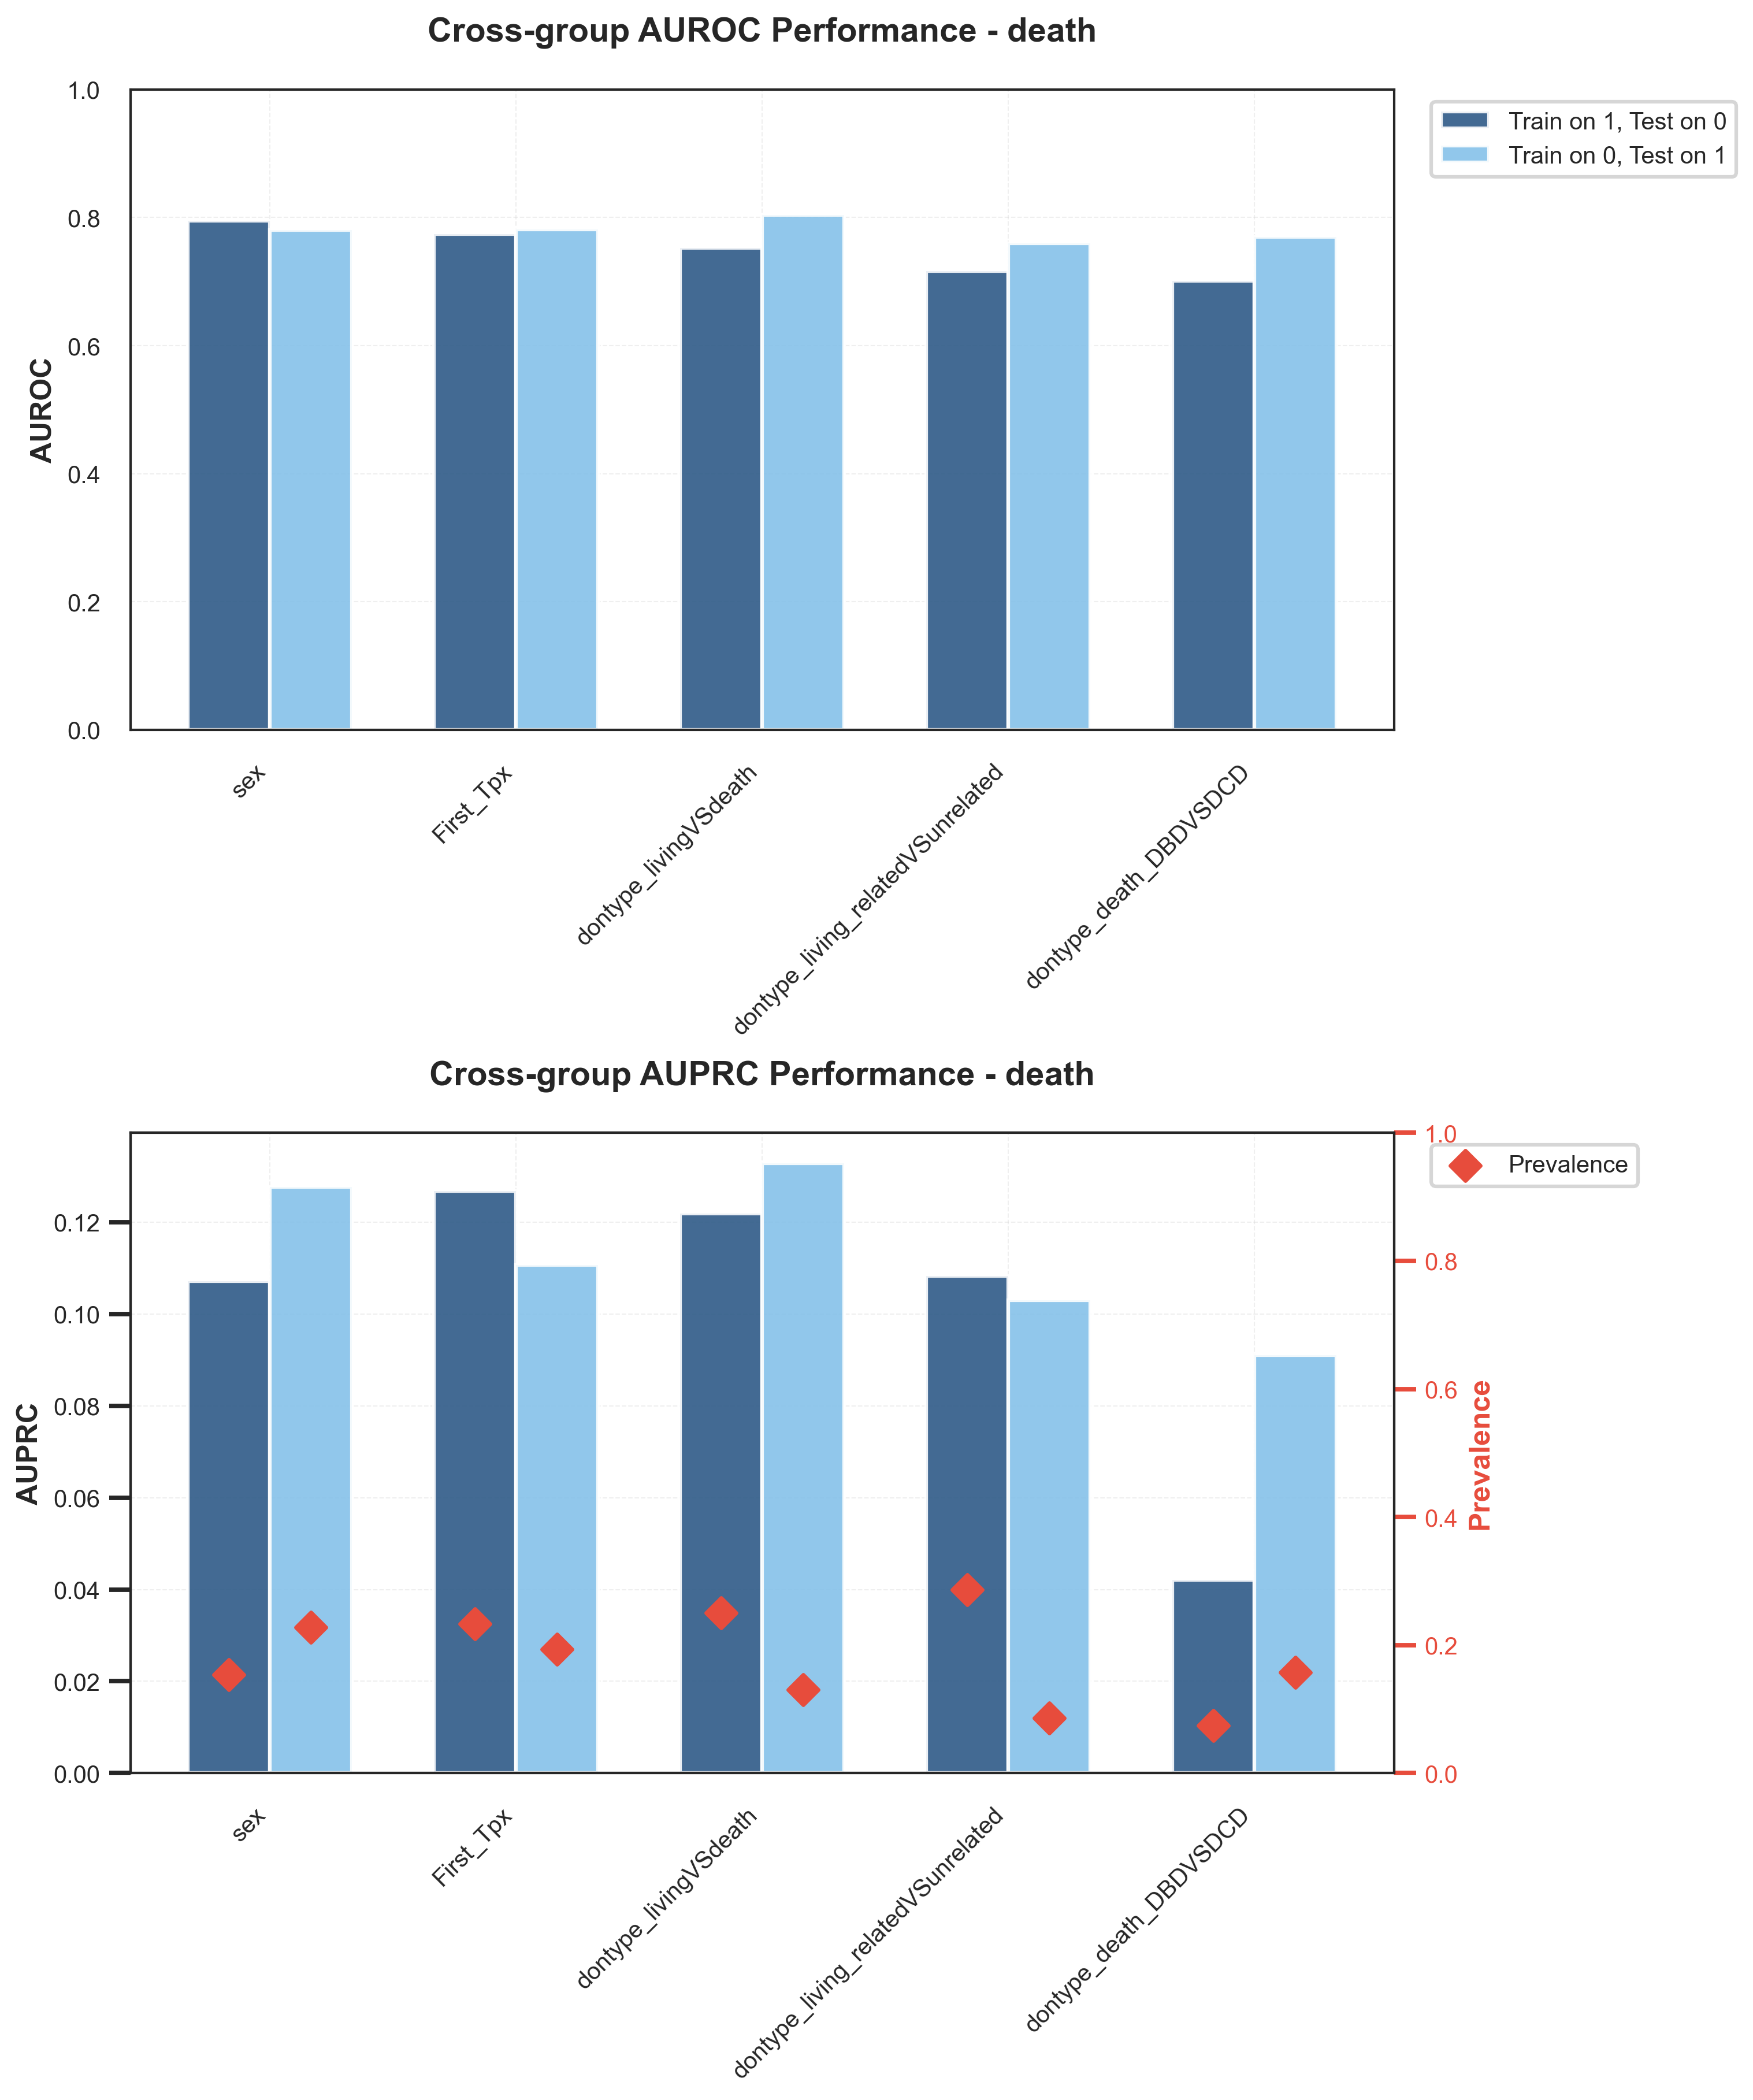

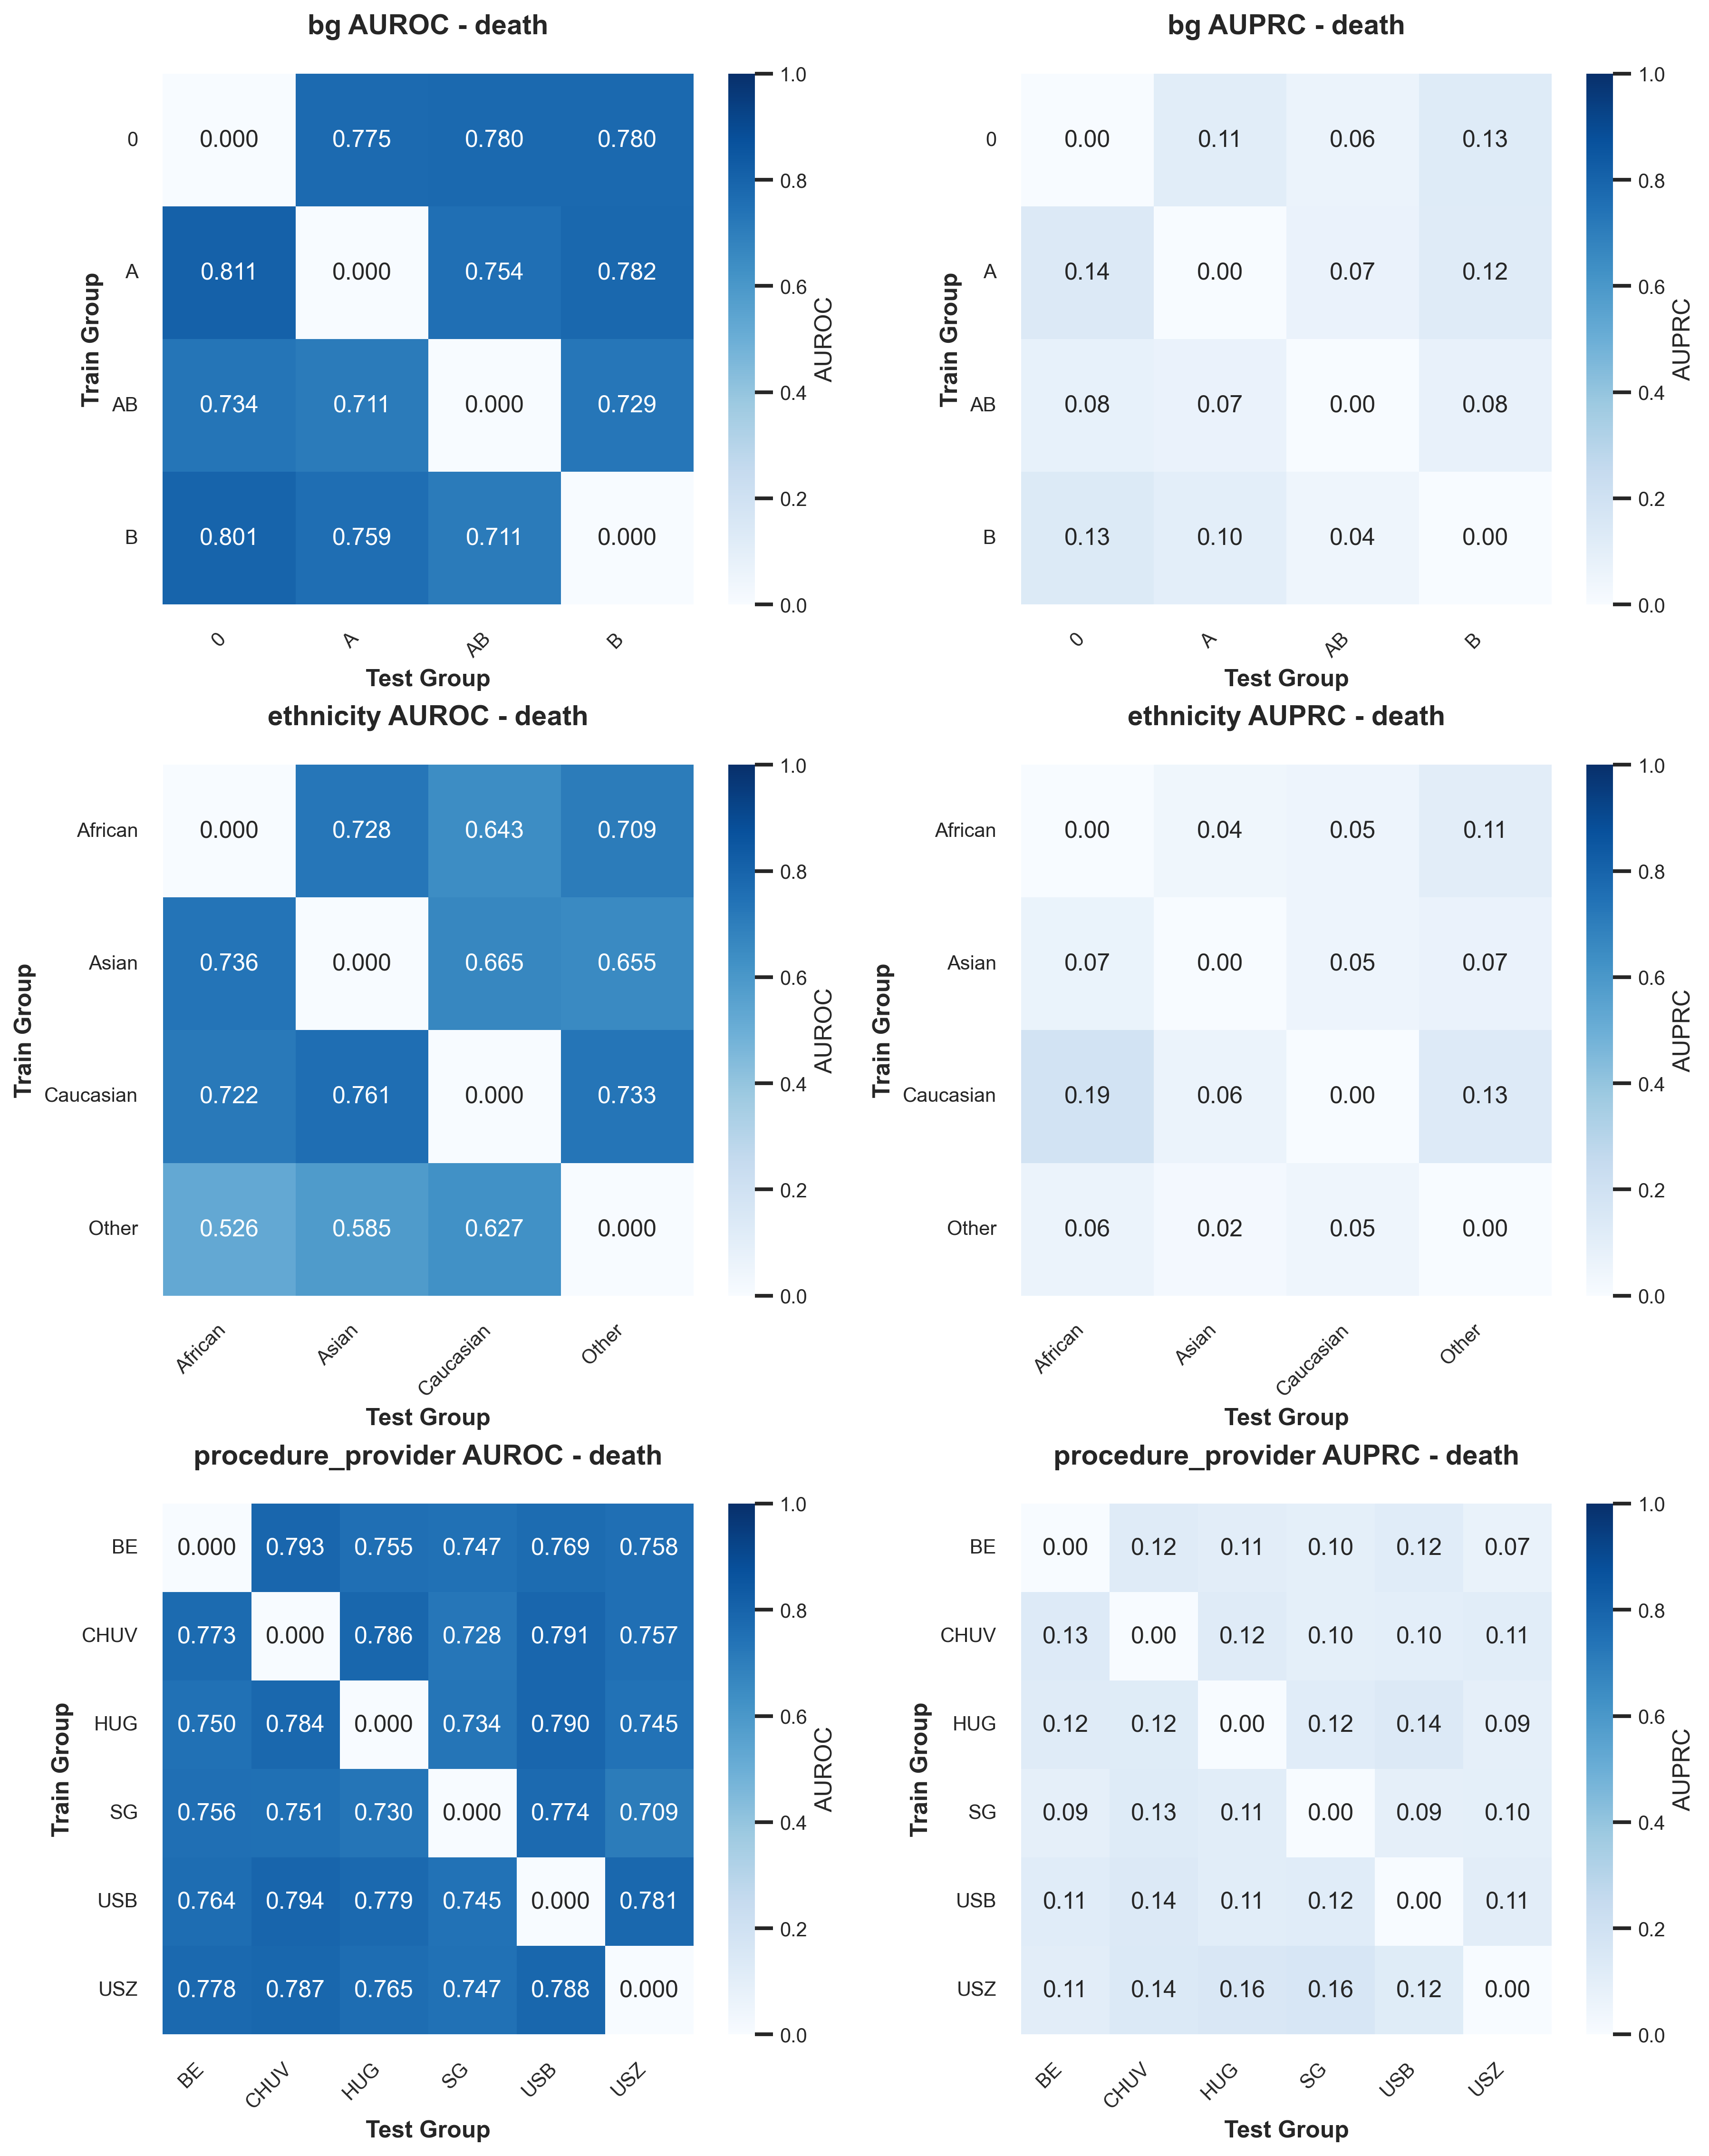

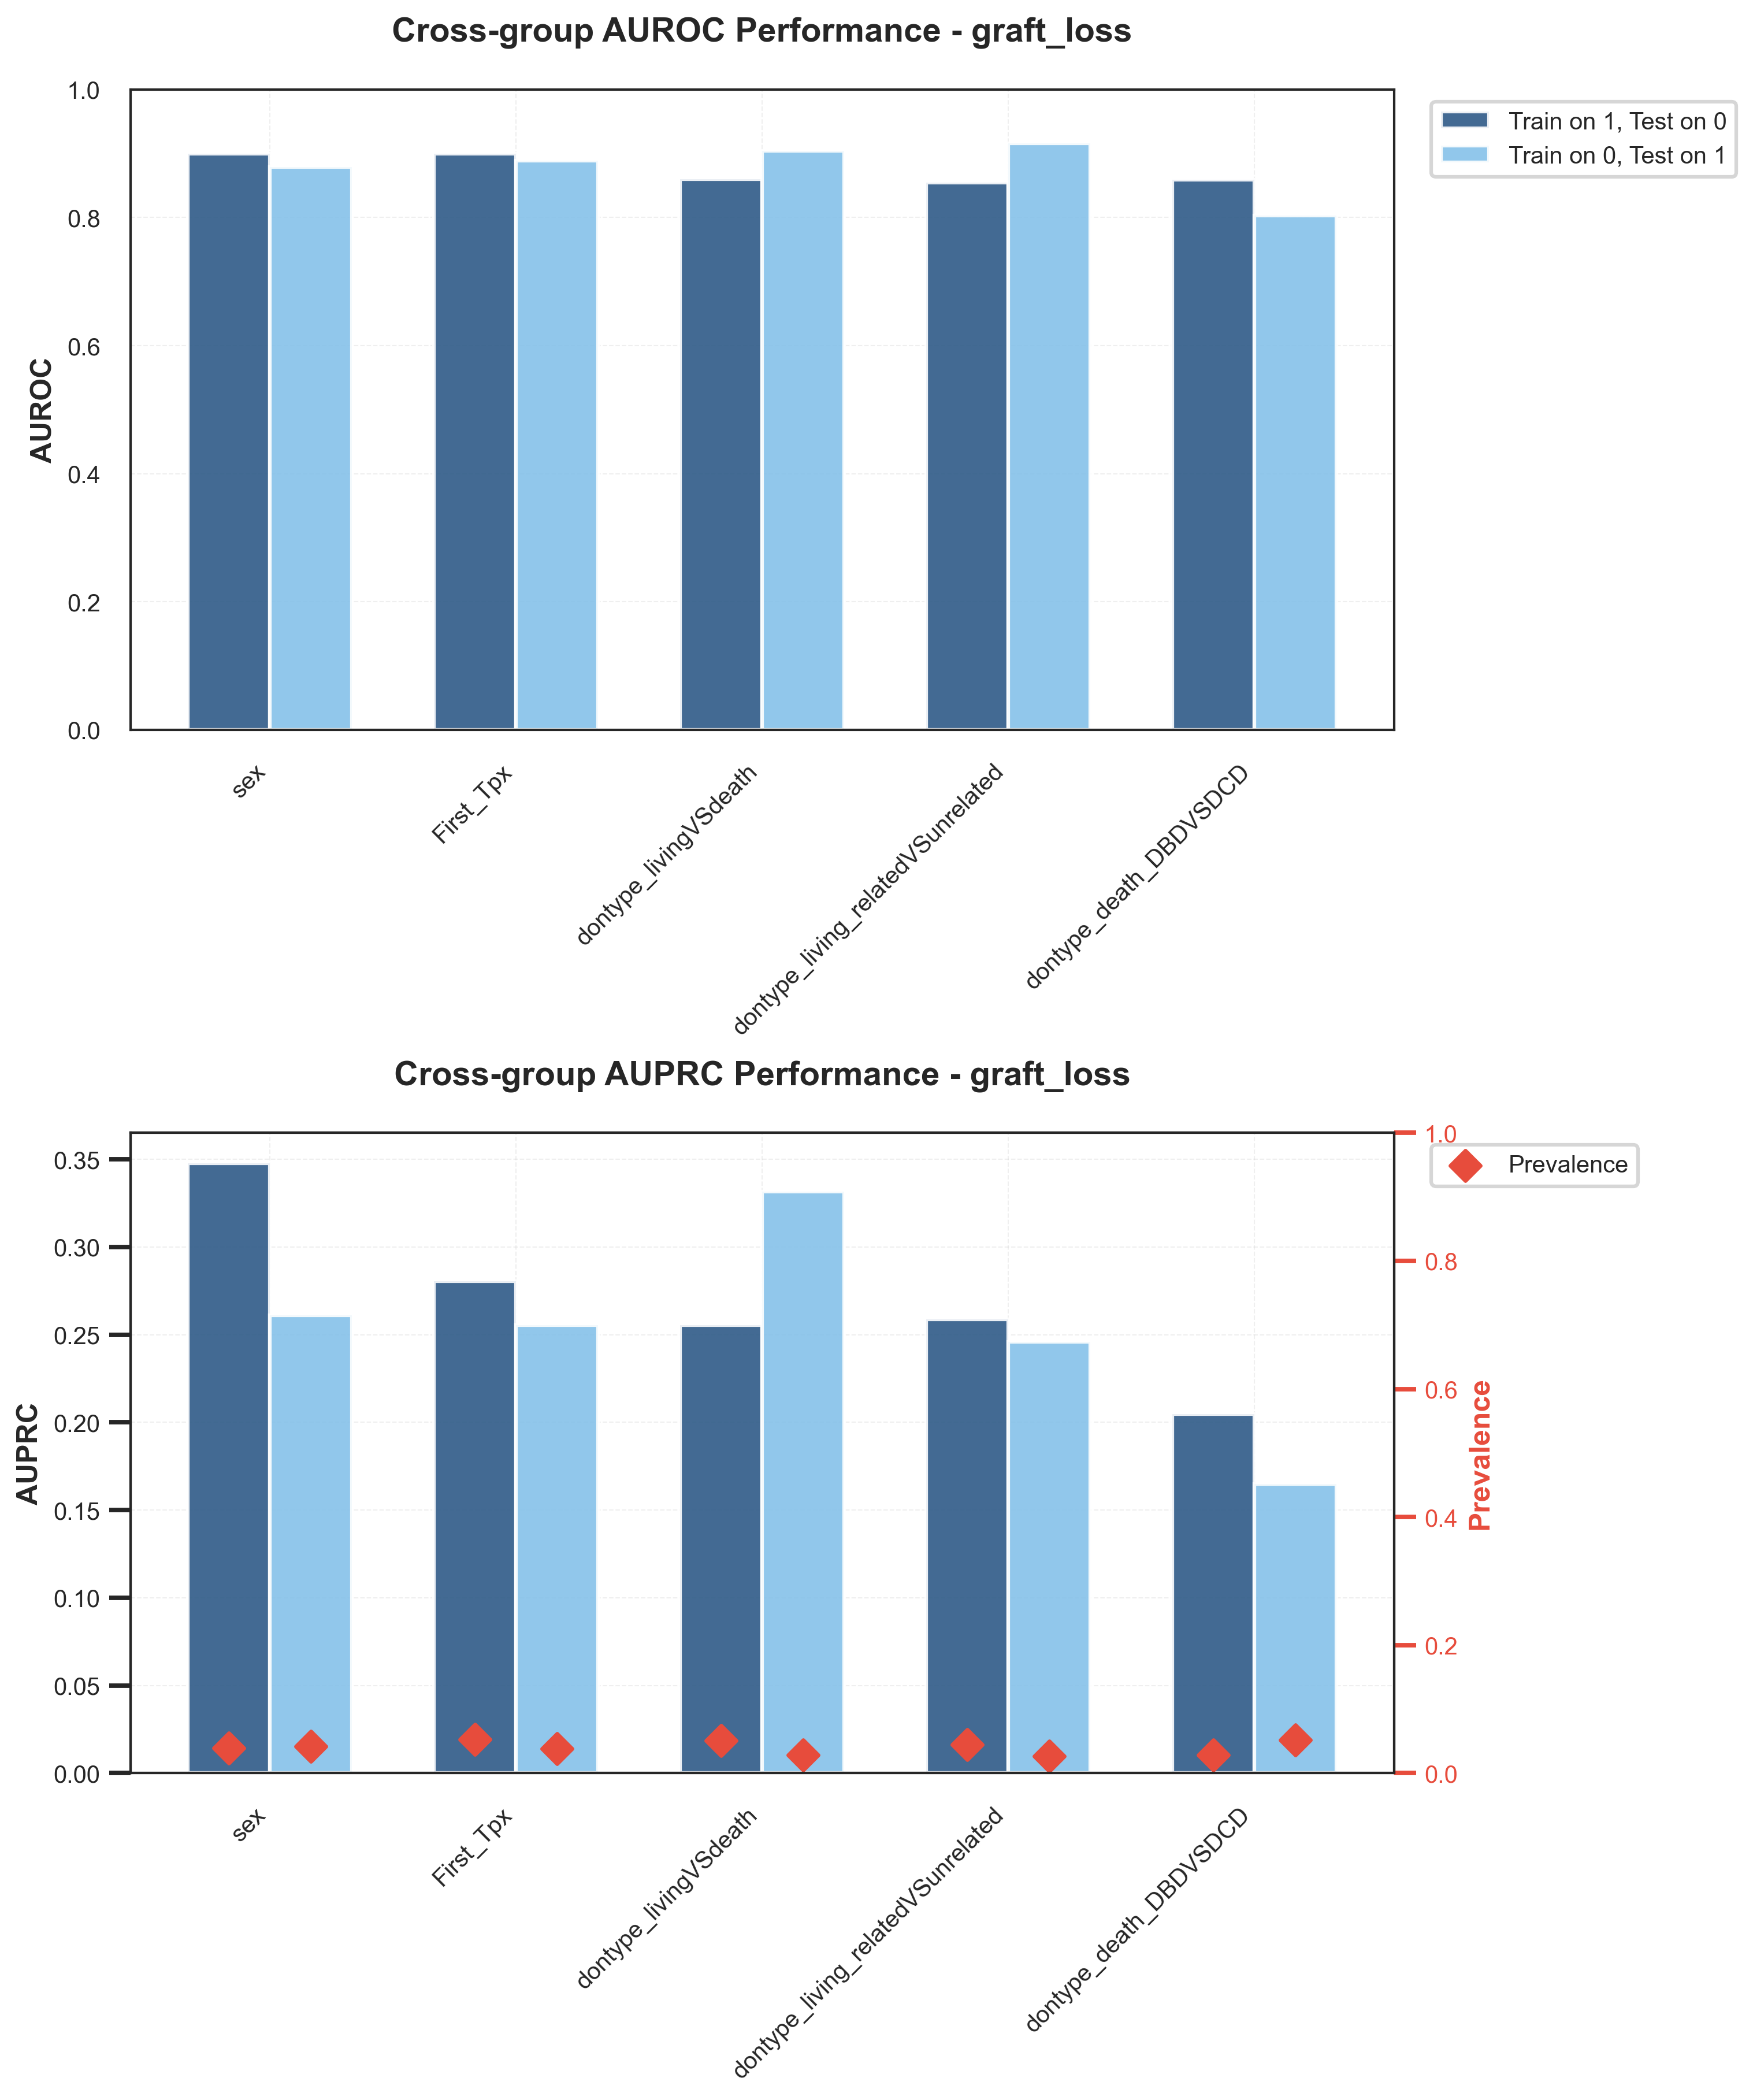

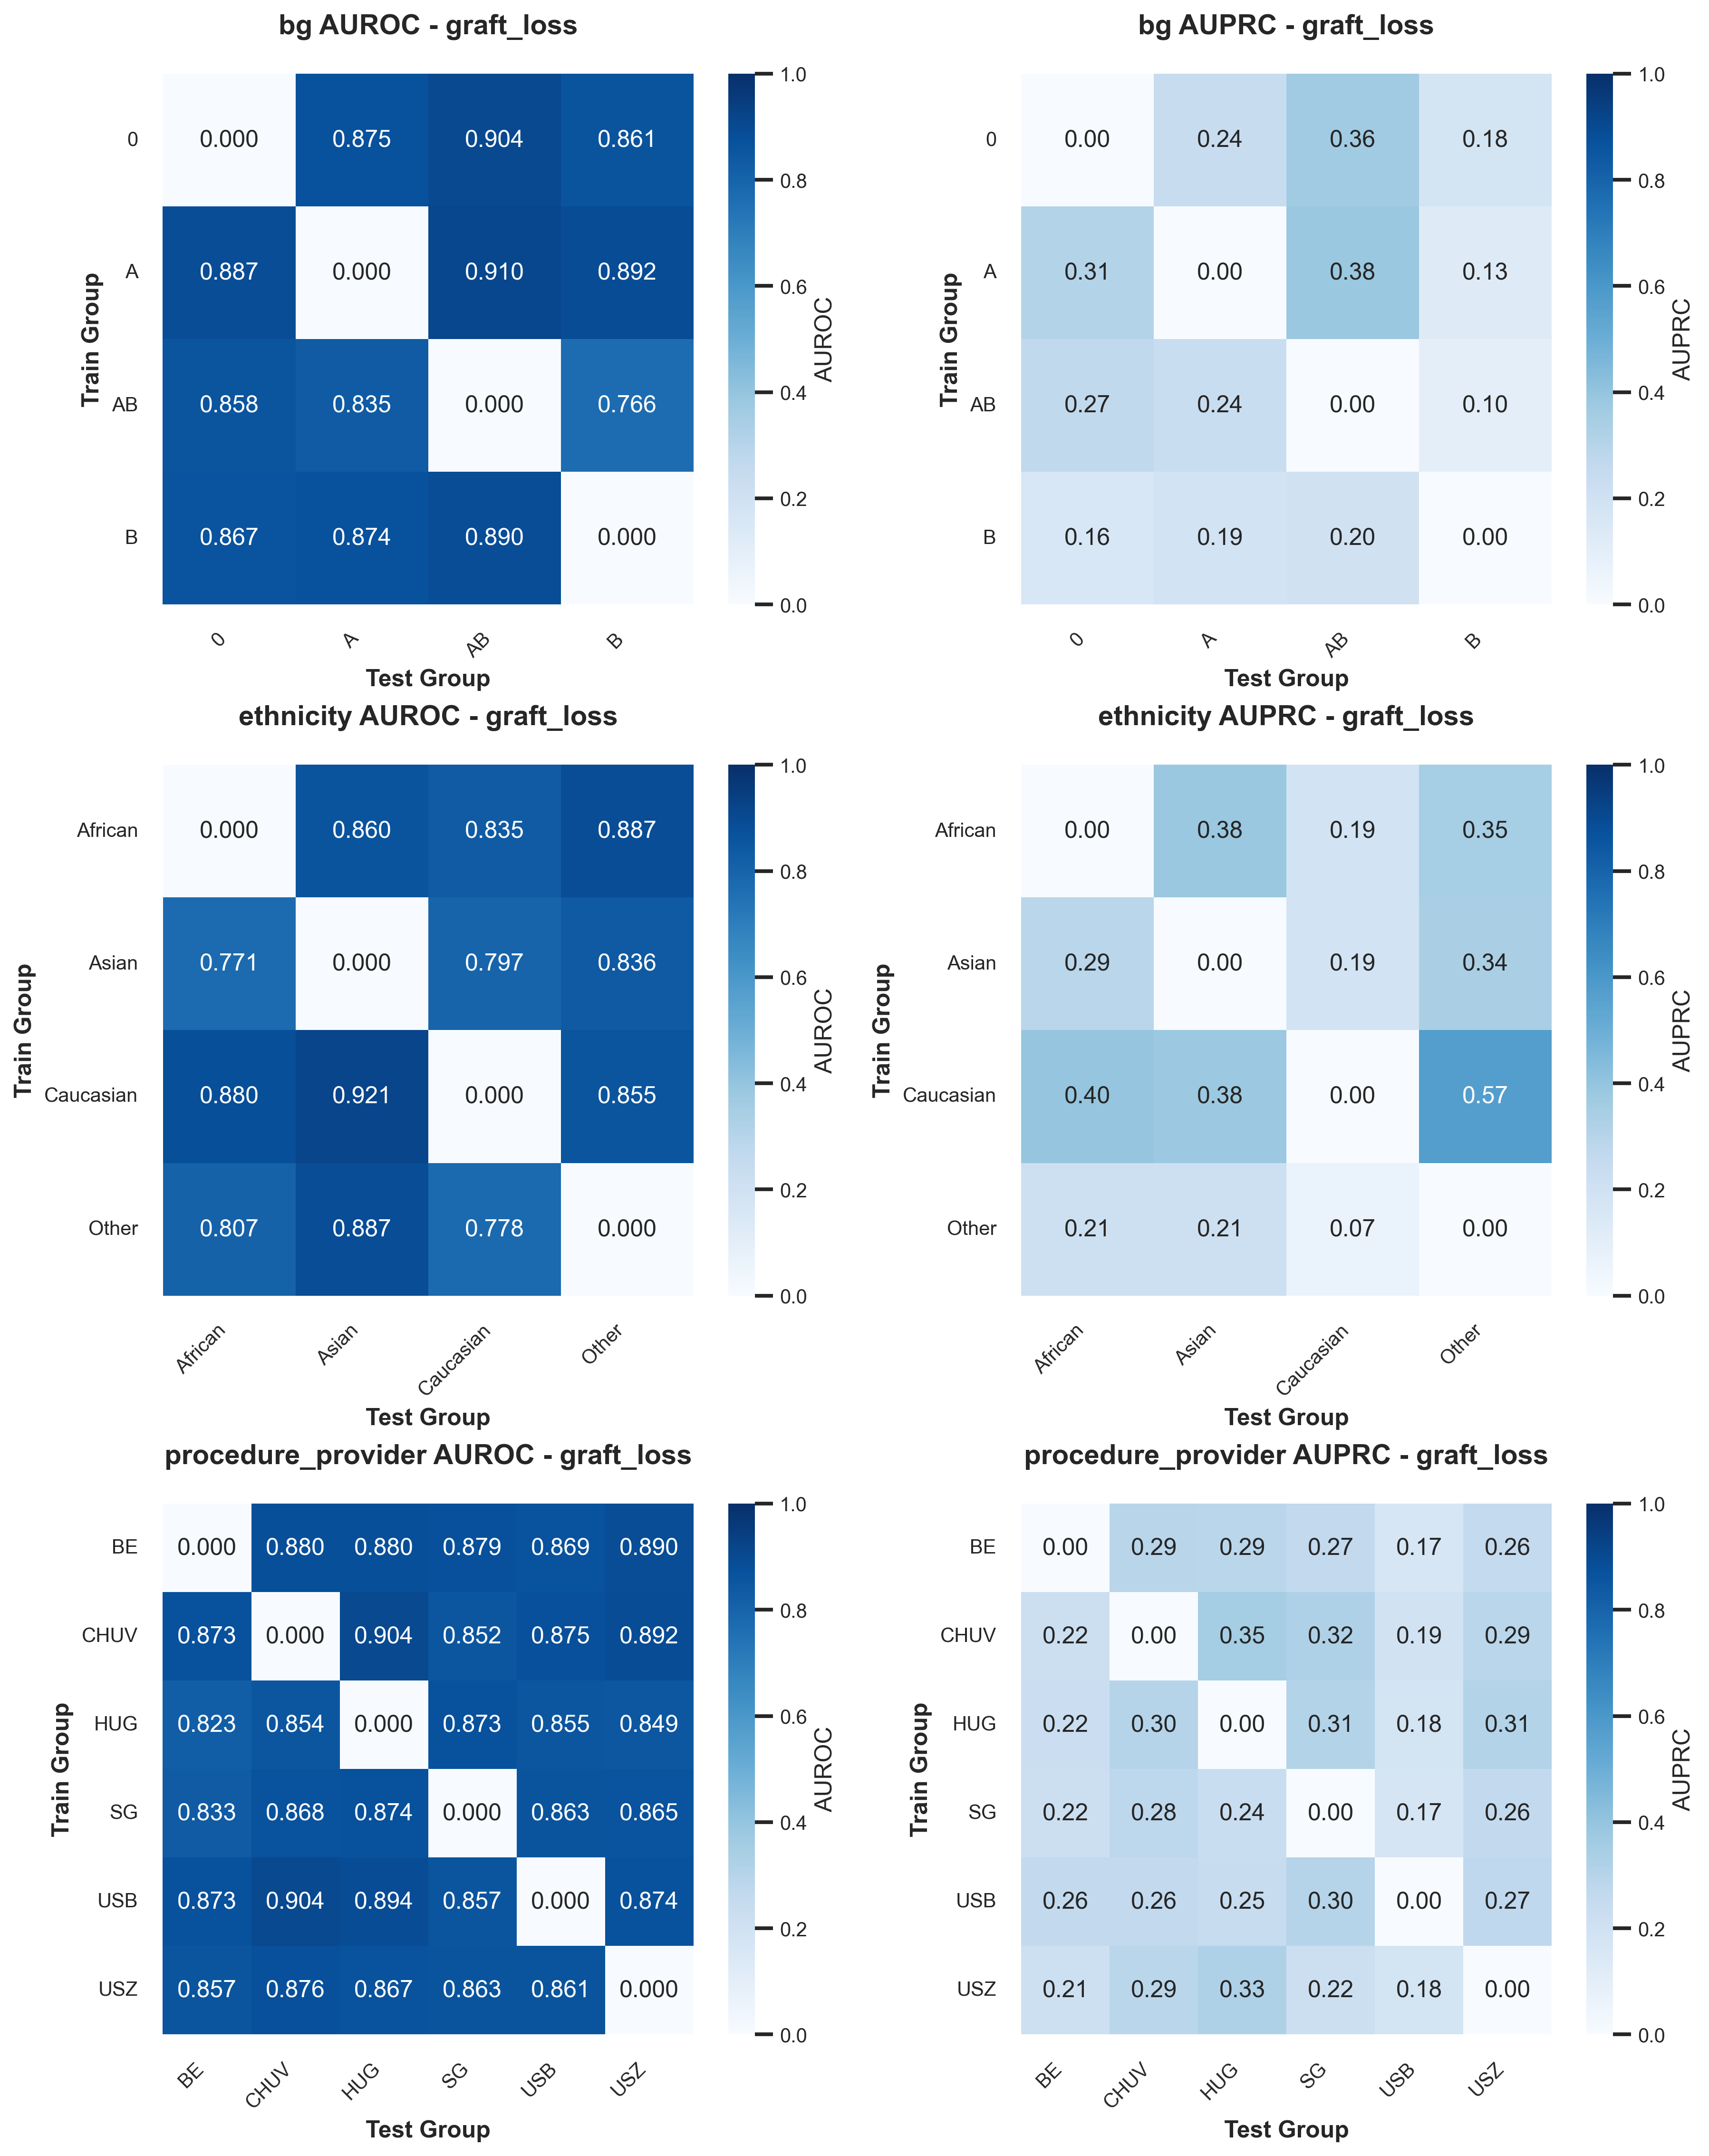

In [97]:
binary_group_cols = ['sex', 'First_Tpx', 'dontype_livingVSdeath']
special_binary_group_cols = ['dontype_living_relatedVSunrelated', 'dontype_death_DBDVSDCD']
multi_class_group_cols = ['bg', 'ethnicity', 'procedure_provider']
cross_group_predictions = pd.read_csv('real777/results/cross_cohort_validation.csv', index_col=0)
# Generate plots for both outcomes
figures = visualize_cross_group_evaluation(
    cross_group_predictions,
    binary_group_cols,
    special_binary_group_cols,
    multi_class_group_cols
)

# Save figures for each outcome
for outcome, (binary_fig, multiclass_fig) in figures.items():
    binary_fig.savefig(f'Manuscript Figures/Supp_cross_group_performance_binary_{outcome}.png', 
                      dpi=300, bbox_inches='tight')
    multiclass_fig.savefig(f'Manuscript Figures/Supp_cross_group_performance_multiclass_{outcome}.png', 
                          dpi=300, bbox_inches='tight')

## Sub cohort Temporal analysis

In [20]:
def analyze_temporal_performance(
    data: pd.DataFrame, predictions: pd.DataFrame, group_column: str
) -> pd.DataFrame:
    """
    Analyze model performance over time for different groups.
    """
    results = []
    group_mapping = data[group_column].to_dict()
    outcomes = predictions["outcome"].unique()
    years = predictions["target_year"].unique()

    for outcome in outcomes:
        outcome_mask = predictions["outcome"] == outcome

        for year in years:
            year_mask = predictions["target_year"] == year
            year_data = predictions[outcome_mask & year_mask]
            if year_data.empty:
                continue

            valid_preds = year_data["prob"].values
            valid_actuals = year_data["label"].values
            patient_ids = [idx for idx in year_data["soaskey"]]
            valid_groups = [group_mapping.get(pid) for pid in patient_ids]
            valid_groups = np.array(valid_groups)

            for group in np.unique(valid_groups):
                if group is None:
                    continue

                group_mask = valid_groups == group
                group_preds = valid_preds[group_mask]
                group_actuals = valid_actuals[group_mask]

                if len(group_preds) == 0 or len(np.unique(group_actuals)) < 2:
                    continue

                try:
                    auc = roc_auc_score(group_actuals, group_preds)
                    auprc = average_precision_score(group_actuals, group_preds)
                except ValueError:
                    continue

                prevalence = np.mean(group_actuals)

                results.append(
                    {
                        "outcome": outcome,
                        "year": year,
                        "group": group,
                        "auc": auc,
                        "auprc": auprc,
                        "n_samples": len(group_preds),
                        "prevalence": prevalence,
                    }
                )

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values(["outcome", "group", "year"])
    results_df["outcome_type"] = results_df["outcome"].str.split("_y", expand=True)[0]
    return results_df



def plot_combined_performance(
    results: pd.DataFrame, group_column: str
):
    """
    Plot performance metrics for binary group comparisons.
    
    Parameters:
    results (pd.DataFrame): DataFrame containing performance results
    group_column (str): Column name for binary grouping (e.g., 'sex', 'First_Tpx')
    """
    # Define name mappings for binary columns
    name_mapping = {
        "sex": "Sex (Female=0, Male=1)",
        "First_Tpx": "First Transplant",
        "dontype_livingVSdeath": "Living vs. Deceased Donor",
        "dontype_living_relatedVSunrelated": "Living Donor: Related vs. Unrelated",
        "dontype_death_DBDVSDCD": "Deceased Donor: DBD vs. DCD"
    }

    # Define binary group styles with proper naming
    group_styles = {
        "0": {"marker": "o", "linestyle": "-", "name": "Group 0"},
        "1": {"marker": "s", "linestyle": "--", "name": "Group 1"},
        "0.0": {"marker": "o", "linestyle": "-", "name": "Group 0"},
        "1.0": {"marker": "s", "linestyle": "--", "name": "Group 1"},
        "Female": {"marker": "o", "linestyle": "-", "name": "Female"},
        "Male": {"marker": "s", "linestyle": "--", "name": "Male"},
        "True": {"marker": "o", "linestyle": "-", "name": "Yes"},
        "False": {"marker": "s", "linestyle": "--", "name": "No"},
        "Living": {"marker": "o", "linestyle": "-", "name": "Living"},
        "Deceased": {"marker": "s", "linestyle": "--", "name": "Deceased"},
        "Related": {"marker": "o", "linestyle": "-", "name": "Related"},
        "Unrelated": {"marker": "s", "linestyle": "--", "name": "Unrelated"},
        "DBD": {"marker": "o", "linestyle": "-", "name": "DBD"},
        "DCD": {"marker": "s", "linestyle": "--", "name": "DCD"}
    }

    # Set style for publication-quality fig
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 10,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
        "figure.titlesize": 12,
        "figure.dpi": 300,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.4,
        "lines.linewidth": 2.0,
    })

    # Create figure with 2x2 grid
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.1)

    # Define color palette (colorblind-friendly) for main performance
    outcome_colors = {
        "death": "#0077BB",     # Blue
        "graft_loss": "#EE7733" # Orange
    }

    # Main performance outcomes and groups
    outcomes = sorted(results["outcome_type"].unique())
    groups = sorted(results["group"].unique())

    # Config for the subplots
    plot_configs = [
        {
            "pos": gs[0, 0],
            "metric": "auc",
            "title": "AUROC",
            "ylabel": "AUROC",
            "ylim": (0.5, 1.0),
            "legend_loc": "lower center",
            "legend_bbox": (0.5, 1.15),
        },
        {
            "pos": gs[0, 1],
            "metric": "auprc",
            "title": "AUPRC",
            "ylabel": "AUPRC",
            "ylim": (0, 1.0),
            "legend_loc": "lower center",
            "legend_bbox": (0.5, 1.15),
        },
        {
            "pos": gs[1, 0],
            "metric": "n_samples",
            "title": "Cohort Size",
            "ylabel": "Number of Patients",
        },
        {
            "pos": gs[1, 1],
            "metric": "prevalence",
            "title": "Outcome Prevalence",
            "ylabel": "Prevalence",
            "ylim": (0, 0.1),
        },
    ]

    axes = []
    for config in plot_configs:
        ax = fig.add_subplot(config["pos"])
        axes.append(ax)

        for outcome in outcomes:
            outcome_data = results[results["outcome_type"] == outcome].sort_values("year")
            for group in groups:
                group_data = outcome_data[outcome_data["group"] == group]
                if group_data.empty:
                    continue

                # Convert group to string and get appropriate style
                group_str = str(group)
                style = group_styles.get(group_str, {"marker": "o", "linestyle": "-", "name": str(group)})
                color = outcome_colors[outcome]

                # Plot data
                x_data = group_data["year"].to_numpy()
                y_data = group_data[config["metric"]].to_numpy()

                label = f"{outcome.replace('_', ' ').title()} - {style['name']}"

                ax.plot(
                    x_data,
                    y_data,
                    color=color,
                    linestyle=style["linestyle"],
                    linewidth=2,
                    zorder=3,
                    alpha=0.8,
                    label=label,
                )

                ax.scatter(
                    x_data,
                    y_data,
                    marker=style["marker"],
                    s=100,
                    color=color,
                    edgecolor="white",
                    linewidth=1.5,
                    zorder=4,
                    alpha=0.8,
                )

        ax.set_xlabel("Years after Transplant", labelpad=10)
        ax.set_ylabel(config["ylabel"], labelpad=10)
        ax.set_title(config["title"], pad=20)
        ax.grid(True, linestyle="--", alpha=0.3, zorder=1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if "ylim" in config:
            ax.set_ylim(config["ylim"])
        ax.set_xticks(sorted(results["year"].unique()))

        # Position legend if needed
        if "legend_loc" in config:
            legend_title = name_mapping.get(group_column, group_column.replace("_", " ").title())
            legend = ax.legend(
                title=legend_title,
                bbox_to_anchor=config["legend_bbox"],
                loc=config["legend_loc"],
                frameon=True,
                edgecolor="none",
                ncol=2,
            )
            legend.get_frame().set_linewidth(0.8)

    # Use mapped name for title if available
    title_text = name_mapping.get(group_column, group_column.replace("_", " ").title())

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

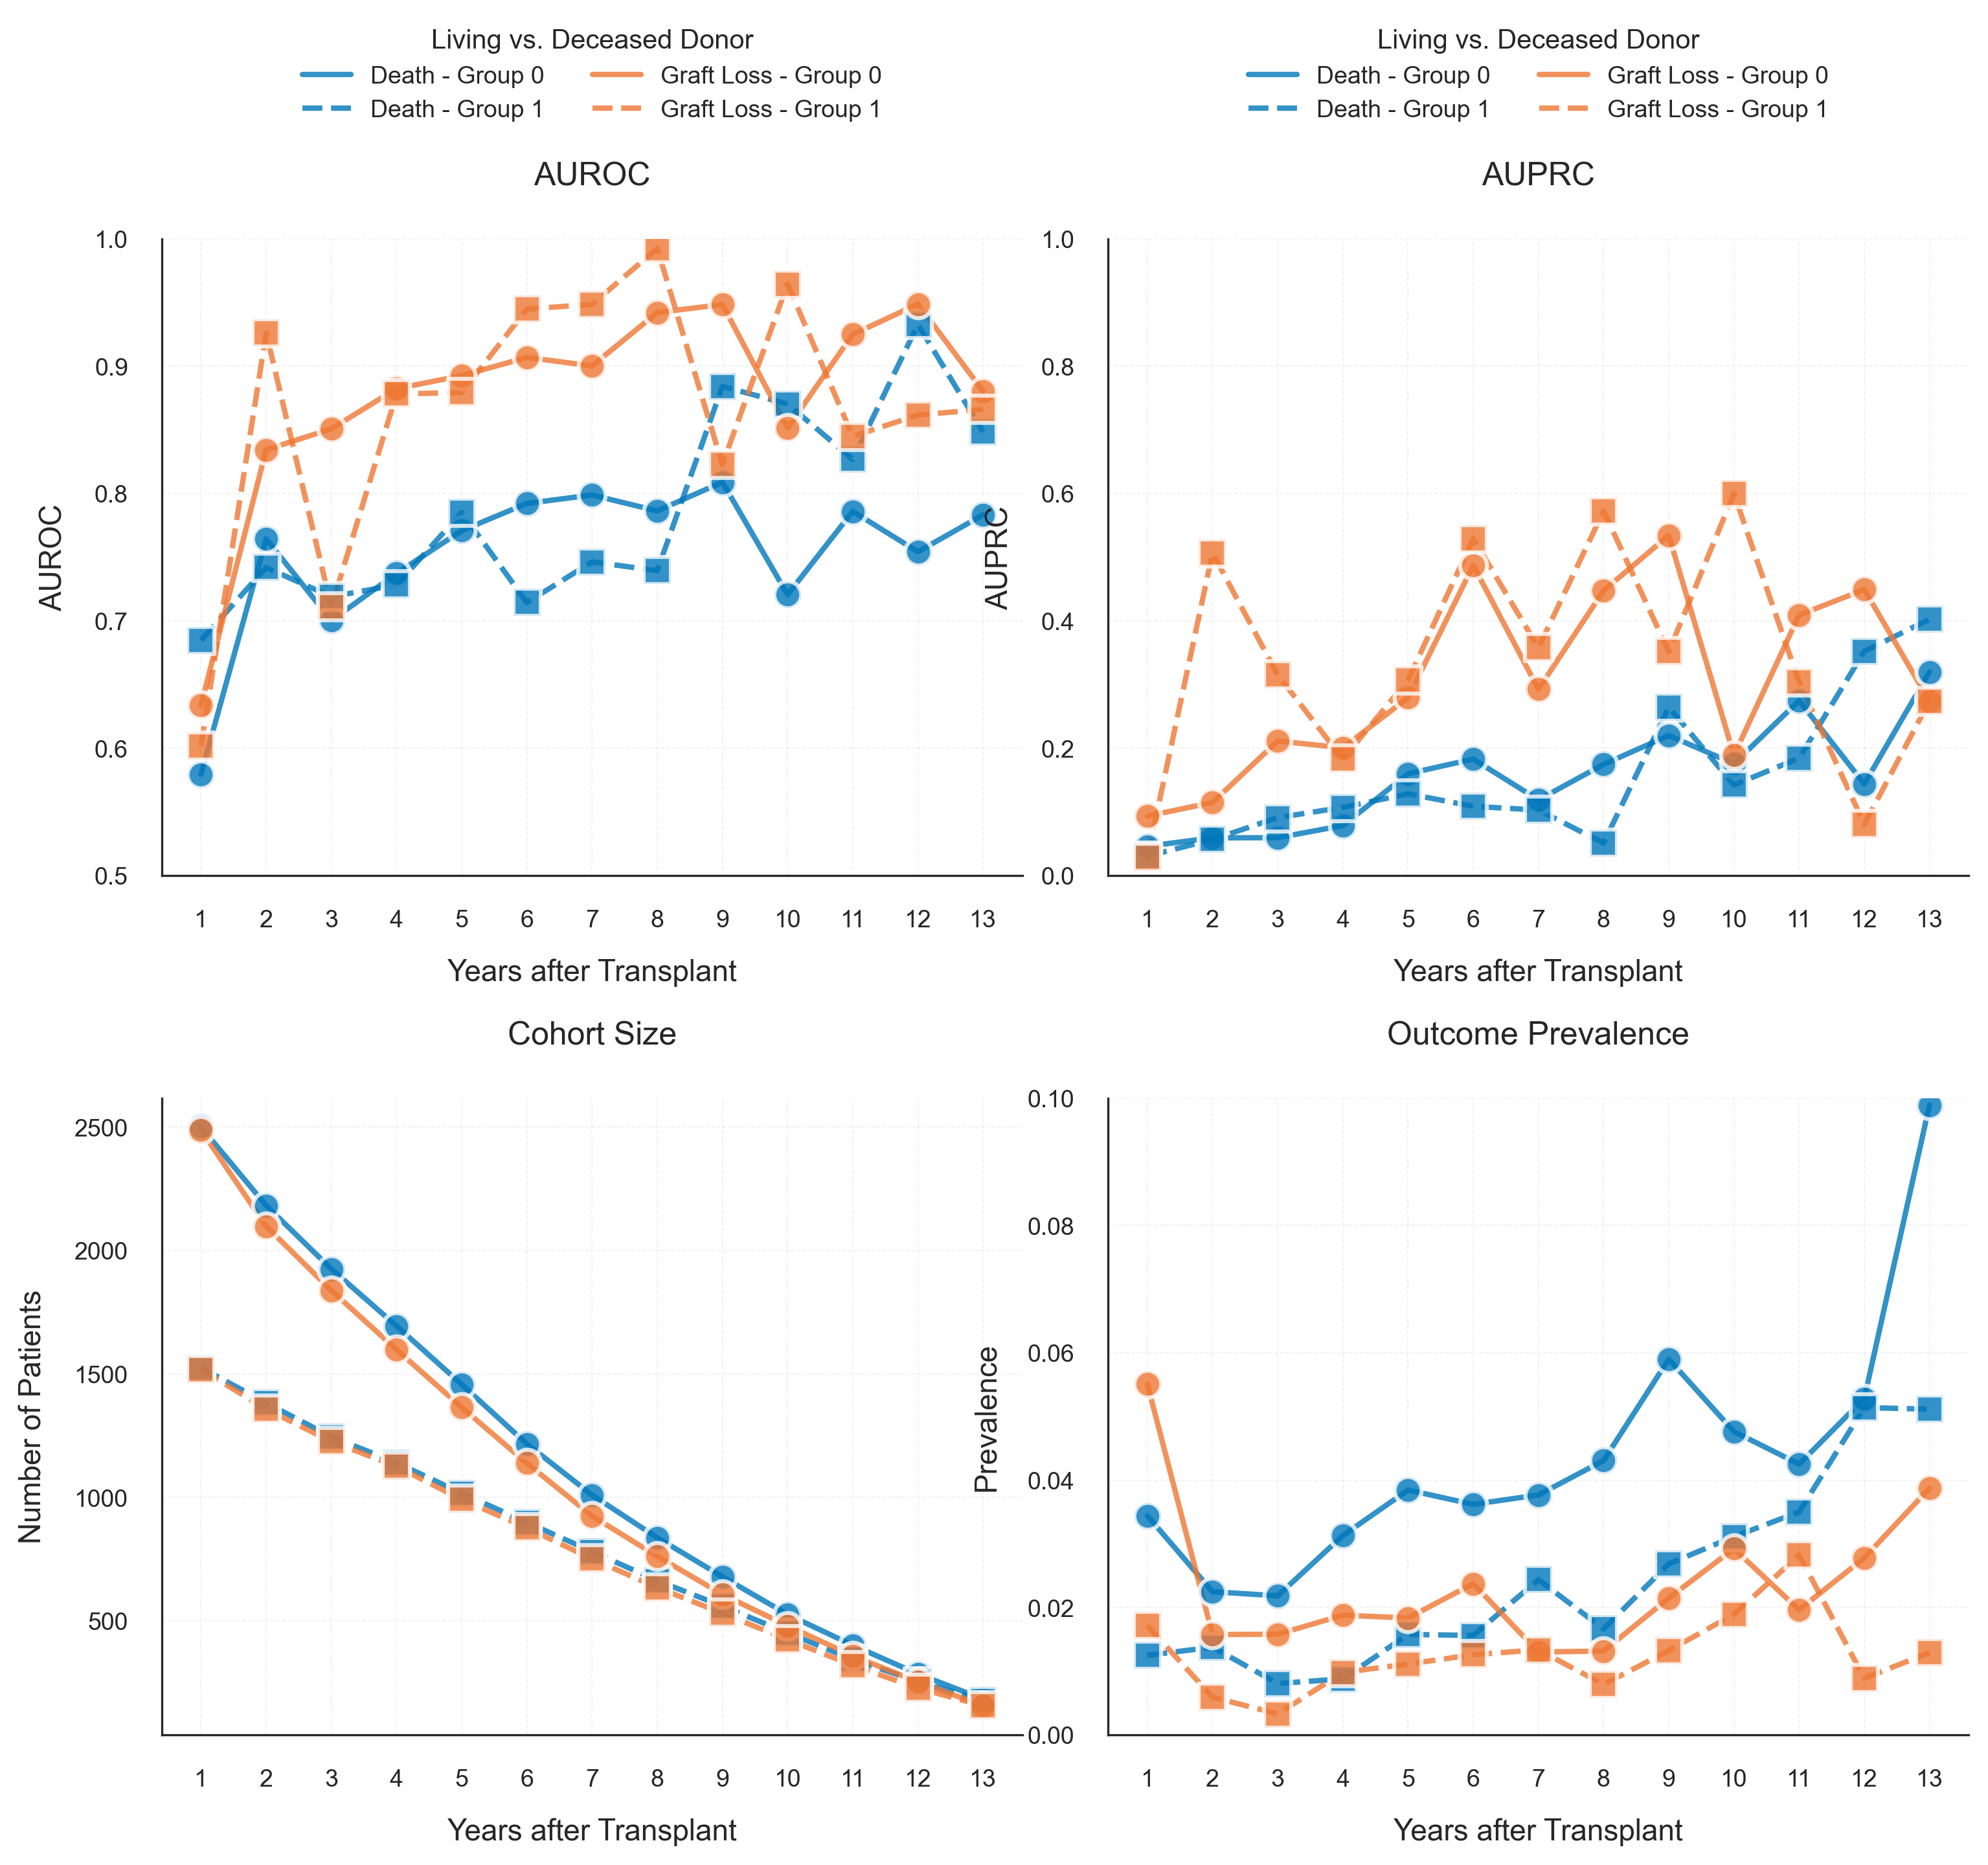

In [26]:

group_column = 'dontype_livingVSdeath'
result_df = pd.read_csv(
    f"{dataset}/results/next_year_prediction_results_{model_name}_multi_year_training_best_model.csv"
)
stratified_results_df = analyze_temporal_performance(data, result_df, group_column=group_column)

fig = plot_combined_performance(stratified_results_df, 
                                group_column)
fig.savefig(f'Manuscript Figures/Supp_subcohort_analysis_{group_column}.png', dpi=200)